In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys 
import optuna 
import pandas as pd
import pickle

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')
import matplotlib as mpl
print(mpl.style.available)
mpl.style.use('seaborn-talk')

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [3]:
data_dir = '/afs/csail.mit.edu/u/z/zeshanmh/research/longlearn/data/ml_mmrf/ml_mmrf/output/1_mmrf_dataset_2mos_type.pkl'
with open(data_dir, 'rb') as f:
    dset = pickle.load(f)
print(dset.keys())

dict_keys(['treatment', 'labs', 'baseline', 'os', 'pfs_nonasct', 'pfs_asct', 'pfs', 'trt_outcomes'])


In [4]:
dset['os']

{'pids': array(['MMRF_1014', 'MMRF_1024', 'MMRF_1033', ..., 'MMRF_2754',
        'MMRF_2781', 'MMRF_2840'], dtype=object),
 'data': array([19.766666666666666, 40.85, 38.35, ..., 0.13333333333333333,
        3.466666666666667, 0.4166666666666667], dtype=object),
 'obs': array([0, 0, 0, ..., 1, 1, 1], dtype=object),
 'names': array(['overall_survival'], dtype='<U16')}

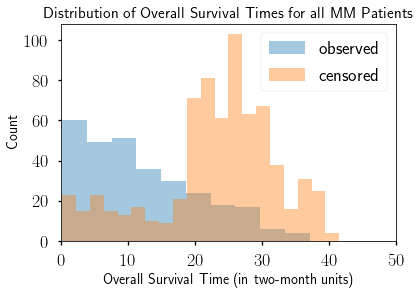

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.distplot(dset['os']['data'][dset['os']['obs']==1],label='observed', ax = ax, kde=False)
sns.distplot(dset['os']['data'][dset['os']['obs']==0],label='censored', ax = ax, kde=False)
ax.legend(fontsize=18)
ax.set_xlim([0,50])
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_title('Distribution of Overall Survival Times for all MM Patients')
ax.set_ylabel('Count')
ax.set_xlabel('Overall Survival Time (in two-month units)')
fig.savefig('./hist_os.pdf',bbox_inches='tight')

In [22]:
print(dset['os']['data'].shape)
print(f"number of observed patients with OS time: {np.sum(dset['os']['obs'])}")
print(f"number of censored patients with OS time: {np.where(dset['os']['obs'] == 0.)[0].shape[0]}")


(1001,)
number of observed patients with OS time: 295
number of observed patients with OS time: 706


In [27]:
print(dset['pfs_nonasct']['data'].shape)
print(f"number of observed patients (non-ASCT) with PFS time: {np.sum(dset['pfs_nonasct']['obs'])}")
print(f"number of censored patients (non-ASCT) with PFS time: {np.where(dset['pfs_nonasct']['obs'] == 0.)[0].shape[0]}")

(501,)
number of observed patients (non-ASCT) with PFS time: 382
number of censored patients (non-ASCT) with PFS time: 119


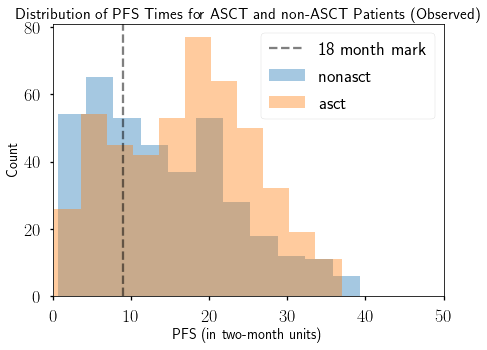

In [68]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
dobs = np.copy(dset['pfs_nonasct']['data'][dset['pfs_nonasct']['obs']==1])
dobs_as = np.copy(dset['pfs_asct']['data'][dset['pfs_asct']['obs']==1])
# print(dobs[dobs<10].shape)
ax.axvline(x=9,color='k',linestyle='--', alpha=0.5, label='18 month mark')
sns.distplot(dobs,label='nonasct', ax = ax, kde=False)
sns.distplot(dobs_as,label='asct', ax = ax, kde=False)
# sns.distplot(dset['pfs_nonasct']['data'][dset['pfs_nonasct']['obs']==0],label='censored', ax = ax, kde=False)
ax.legend(fontsize=18)
ax.set_xlim([0,50])
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_title('Distribution of PFS Times for ASCT and non-ASCT Patients (Observed)')
ax.set_ylabel('Count')
ax.set_xlabel('PFS (in two-month units)')
fig.savefig('./hist_pfs_nonasct.pdf',bbox_inches='tight')


In [29]:
print(dset['pfs_asct']['data'].shape)
print(f"number of observed patients (ASCT) with PFS time: {np.sum(dset['pfs_asct']['obs'])}")
print(f"number of censored patients (ASCT) with PFS time: {np.where(dset['pfs_asct']['obs'] == 0.)[0].shape[0]}")

(600,)
number of observed patients (ASCT) with PFS time: 473
number of censored patients (ASCT) with PFS time: 127


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
dobs = np.copy(dset['pfs_asct']['data'][dset['pfs_nonasct']['obs']==1])
# print(dobs[dobs<10].shape)
# ax.axvline(x=9,color='k',linestyle='--', alpha=0.5, label='18 month mark')
sns.distplot(dobs,label='observed', ax = ax, kde=False)
# sns.distplot(dset['pfs_nonasct']['data'][dset['pfs_nonasct']['obs']==0],label='censored', ax = ax, kde=False)
ax.legend(fontsize=18)
# ax.set_xlim([0,70])
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_title('Distribution of PFS Times for ASCT Patients')
ax.set_ylabel('Count')
ax.set_xlabel('Overall Survival Time (in two-month units)')
fig.savefig('./hist_pfs_nonasct.pdf',bbox_inches='tight')


In [5]:
fold = 2
from data import *
data_dir = '/afs/csail.mit.edu/u/z/zeshanmh/research/longlearn/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_trt_resp_ind_seed0.pkl'
ddata = load_mmrf(fold_span = [fold], \
                              digitize_K = 0, \
                              digitize_method = 'uniform', \
                              data_dir=data_dir, \
                              restrict_markers=['serum_m_protein', 'syn_marker'], \
                              add_syn_marker=True, \
                              window='first_second', \
                              data_aug=False, \
                              ablation=False, \
                              feats=[])


loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/longlearn/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_trt_resp_ind_seed0.pkl
adding synthetic marker in fold 2, set train...
new shape of X: (212, 36, 17)
new shape of M: (212, 36, 17)
adding synthetic marker in fold 2, set valid...
new shape of X: (71, 36, 17)
new shape of M: (71, 36, 17)
adding synthetic marker in fold 2, set test...
new shape of X: (96, 36, 17)
new shape of M: (96, 36, 17)
restricting longitudinal markers in fold 2, set train...
new shape of X: (212, 36, 2)
new shape of M: (212, 36, 2)
restricting longitudinal markers in fold 2, set valid...
new shape of X: (71, 36, 2)
new shape of M: (71, 36, 2)
restricting longitudinal markers in fold 2, set test...
new shape of X: (96, 36, 2)
new shape of M: (96, 36, 2)


In [11]:
print(ddata[fold]['test']['feature_names'])
Bvalid = ddata[fold]['valid']['b']
Btest  = ddata[fold]['test']['b']

Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')


Text(0.5, 0, 'Feature')

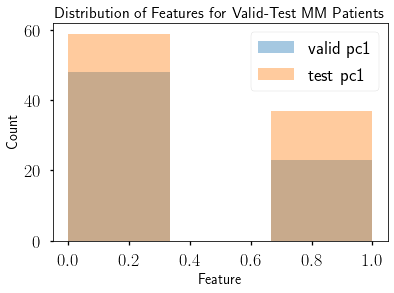

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.distplot(Bvalid[:,15],label='valid pc1', ax = ax, kde=False)
sns.distplot(Btest[:,15],label='test pc1', ax = ax, kde=False)
ax.legend(fontsize=18)
# ax.set_xlim([0,50])
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_title('Distribution of Features for Valid-Test MM Patients')
ax.set_ylabel('Count')
ax.set_xlabel('Feature')
# fig.savefig('./hist_os.pdf',bbox_inches='tight')


In [19]:
import os
fdir = '/afs/csail.mit.edu/group/clinicalml/datasets/multiple_myeloma/ia15'
# fdir = os.path.join(fdir,'CoMMpass_'+self.ia_version.upper()+'_FlatFiles/*.csv')
survival_ASCT = pd.read_csv(os.path.join(fdir,'MMRF_OS_PFS_ASCT.csv'), delimiter=',', encoding='latin-1')
survival_nonASCT = pd.read_csv(os.path.join(fdir,'MMRF_OS_PFS_non-ASCT.csv'), delimiter=',', encoding='latin-1')
nonASCT_PFS = survival_nonASCT[['Patient', 'Progression', 'Dead', 'Progression Day', 'Last Alive/Dead']]
nonASCT_PFS['Progression']=nonASCT_PFS.Progression.map({'yes':1, 'no':0})
nonASCT_PFS['Dead']=nonASCT_PFS.Dead.map({'yes':1, 'no':0})
#if either died or progressed, should have a "1" under "progress" (0 implies censorship)
nonASCT_PFS['progress'] = nonASCT_PFS['Dead'] + nonASCT_PFS['Progression']
nonASCT_PFS['progress'] = np.where(nonASCT_PFS['progress']==0, 0, 1)
#progress_day should be min of Progression Day and Last Alive.Dead
# nonASCT_PFS.loc[nonASCT_PFS['Progression Day']=="none",'Progression Day']=9999999 #temporarily map no progression to large number to help engineer col
print(nonASCT_PFS['Progression Day'].values)
nonASCT_PFS['Progression Day'] = nonASCT_PFS['Progression Day'].fillna(nonASCT_PFS['Last Alive/Dead'])
print(nonASCT_PFS['Progression Day'].values)

nonASCT_PFS['progress_day'] = nonASCT_PFS[['Progression Day', 'Last Alive/Dead']].astype(int).min(axis=1) #both columns must be type int before comparing
print(nonASCT_PFS.progress.value_counts())

sub = nonASCT_PFS[nonASCT_PFS['progress_day']<540]
sub2= nonASCT_PFS[nonASCT_PFS['progress_day']>=540]

print(sub2[sub2['progress'] == 1]) # e_bin should be 1; e should be 1 
print(sub2[sub2['progress'] == 0]) # e_bin should be 1; e should be 0
print(sub[sub['progress'] == 1]) # e_bin should be 1; e should be 1
print(sub[sub['progress'] == 0]) # e_bin should be 0; e should be 0

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

[ 274.  654.   nan  218.  248.   42.   nan  562.  703.   71.  541.   nan
   66.  789.  427.  950. 1186.  700.   77.  331.  488. 1073.  491.  282.
  908.  133.   nan  280.   nan   nan  724.   nan 1090.   nan   nan   nan
   nan  343.   nan  455.  256.   nan   nan   nan   nan  708.   nan   nan
   nan   nan   nan 1329.   nan  351.   nan   nan 1472.  840.  624.   nan
   nan   nan  551. 1252.   nan  627.   nan  283.   nan  271.   nan   nan
  389.   nan 1173. 1240.   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan  757.   nan   nan   nan   nan  737.   nan
  970.   nan   nan   nan   nan 1240. 1055.   nan  284.  204.   nan  419.
   nan  385.  199.  609.   nan   nan   nan   nan   nan   nan  394.   nan
   nan  518.  178.   nan  349.  267.  481.  776.   nan   nan 1057.   nan
 1196.  175.   69.   nan   nan   nan  197.  407.  415.   nan   nan   nan
  884.   nan   nan  581.  502.  344.  616.  434.  447.  138. 1158.  312.
  295.  613.  525.   nan  426.   nan   nan   nan  1

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


[ 274.  654. 1753.  218.  248.   42. 2098.  562.  703.   71.  541. 1999.
   66.  789.  427.  950. 1186.  700.   77.  331.  488. 1073.  491.  282.
  908.  133.  668.  280.  152. 1765.  724.  628. 1090.   88.  722. 1170.
 1962.  343. 1124.  455.  256.  167.  320.  267.  778.  708.  120.  259.
  319.   74.  141. 1329. 1886.  351.  692. 2360. 1472.  840.  624. 1282.
 2223.  250.  551. 1252.   85.  627.  519.  283. 2007.  271. 1970. 1920.
  389. 1511. 1173. 1240. 1176. 1733. 1674. 1163. 1625. 1506.  305.  292.
  450. 1505. 1473. 1450. 1421.  757. 1316.   86.  907.  746.  737. 1255.
  970.  520. 1151.  116.  438. 1240. 1055.  111.  284.  204. 1803.  419.
  373.  385.  199.  609. 2360.  601.  268.  153. 1982. 1966.  394.  207.
 1401.  518.  178.  352.  349.  267.  481.  776. 1190. 1442. 1057. 1233.
 1196.  175.   69.  238.  479.  485.  197.  407.  415. 1553. 1371.  201.
  884. 2209. 1785.  581.  502.  344.  616.  434.  447.  138. 1158.  312.
  295.  613.  525. 1119.  426. 1245. 1371. 2165.  1

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    306
0    195
Name: progress, dtype: int64
       Patient  Progression  Dead  Progression Day  Last Alive/Dead  progress  \
1    MMRF_1024            1     0            654.0             2451         1   
2    MMRF_1038            0     1           1753.0             1753         1   
7    MMRF_1129            1     1            562.0              610         1   
8    MMRF_1130            1     0            703.0             2139         1   
10   MMRF_1193            1     1            541.0             1564         1   
..         ...          ...   ...              ...              ...       ...   
430  MMRF_2268            1     0            907.0             1425         1   
432  MMRF_2558            1     0            998.0             1087         1   
433  MMRF_2195            1     0            741.0             1429         1   
434  MMRF_2317            1     0            610.0              610         1   
437  MMRF_2639            1     0            553.0            

In [22]:
survival_ASCT = pd.read_csv(os.path.join(fdir,'MMRF_OS_PFS_ASCT.csv'), delimiter=',', encoding='latin-1')
ASCT_PFS = survival_ASCT[['Patient', 'Post-ASCT Progression', 'Dead', 'Post-ASCT Progression Day', 'Last Alive/Dead']]
ASCT_PFS['Post-ASCT Progression']=ASCT_PFS['Post-ASCT Progression'].map({'yes':1, 'no':0})
ASCT_PFS['Dead']=ASCT_PFS.Dead.map({'yes':1, 'no':0})
#if either died or progressed, should have a "1" under "progress" (0 implies censorship)
ASCT_PFS['progress'] = ASCT_PFS['Dead'] + ASCT_PFS['Post-ASCT Progression']
ASCT_PFS['progress'] = np.where(ASCT_PFS['progress']==0, 0, 1)
#progress_day should be min of Progression Day and Last Alive.Dead
ASCT_PFS.loc[ASCT_PFS['Post-ASCT Progression Day']=="none",'Post-ASCT Progression Day']=9999999 #temporarily map no progression to large number to help engineer col

# ASCT_PFS['progress_day'] = ASCT_PFS[['Progression Day', 'Last Alive/Dead']].astype(int).min(axis=1) #both columns must be type int before comparing
print(ASCT_PFS.progress.value_counts())

ASCT_PFS['Post-ASCT Progression Day'] = ASCT_PFS['Post-ASCT Progression Day'].fillna(ASCT_PFS['Last Alive/Dead'])
ASCT_PFS['progress_day'] = ASCT_PFS[['Post-ASCT Progression Day', 'Last Alive/Dead']].astype(int).min(axis=1) #both columns must be type int before comparing
print(nonASCT_PFS.progress.value_counts())

sub = ASCT_PFS[ASCT_PFS['progress_day']<1080]
sub2= ASCT_PFS[ASCT_PFS['progress_day']>=1080]
# print(sub2[sub2['progress'] == 1]) # e_bin should be 1; e should be 1 
# print(sub2[sub2['progress'] == 0]) # e_bin should be 1; e should be 0
# print(sub[sub['progress'] == 1]) # e_bin should be 1; e should be 1
# print(sub[sub['progress'] == 0]) # e_bin should be 0; e should be 0
print(sub2[sub2['progress'] == 1])
print(sub2[sub2['progress'] == 0])
print(sub[sub['progress'] == 1])
print(sub[sub['progress'] == 0])

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:6: Se

0    344
1    256
Name: progress, dtype: int64


/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


1    306
0    195
Name: progress, dtype: int64
       Patient  Post-ASCT Progression  Dead  Post-ASCT Progression Day  \
0    MMRF_1011                      1     0                     1613.0   
1    MMRF_1013                      1     1                     1333.0   
5    MMRF_1030                      1     0                     1984.0   
9    MMRF_1048                      1     0                     1770.0   
13   MMRF_1057                      1     0                     1138.0   
..         ...                    ...   ...                        ...   
407  MMRF_2284                      1     0                     1317.0   
423  MMRF_2344                      1     0                     1241.0   
480  MMRF_2545                      1     0                     1097.0   
495  MMRF_2587                      1     0                     1178.0   
507  MMRF_2619                      1     0                     1453.0   

     Last Alive/Dead  progress  progress_day  
0               1